In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyfinancialdata
import pandas_techinal_indicators as ta
import trade_functions
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training data

In [2]:
train_data = pyfinancialdata.get_multi_year(
    provider='histdata',
    instrument='SPXUSD',
    years=[2010, 2011, 2012, 2013, 2014, 2015, 2016],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=False,
)

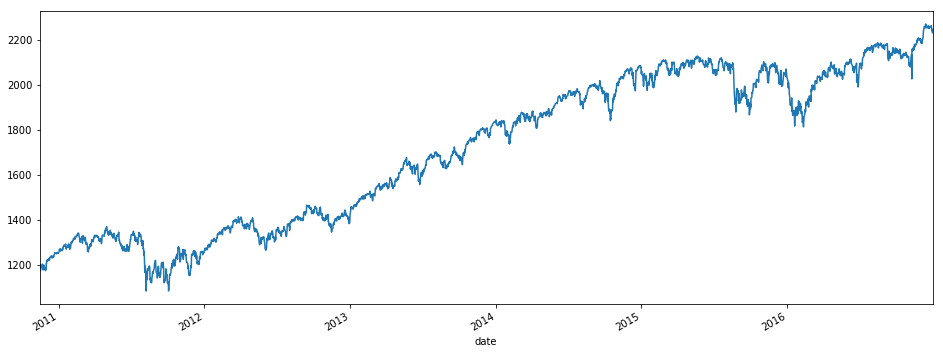

In [3]:
train_data['price'].plot(figsize=(16,6))

In [4]:
# Remove datetime index
train_data.reset_index(inplace=True)
# Add column for the direction of the next bar
# 1 = up, -1 = down
train_data['next_direction'] = np.where(train_data.shift(-1)['price'] > train_data['price'], 1, -1)

In [5]:
# Add features to help predict next_direction
def add_features(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema14'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()
        
    data = ta.macd(data, n_fast=12, n_slow=26)

    return data

In [6]:
# Add features
train_data = add_features(train_data.copy())
# Remove NA rows created from the extra features
train_data = train_data.replace([np.inf, -np.inf], np.nan)
train_data = train_data.dropna()

In [7]:
train_data.tail(5)

,date,close,high,low,open,price,next_direction,RSI_5,SO%d_5,ATR_5,...,CCI_66,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
3480,2016-12-28 12:00:00,2246.75,2254.50,2243.50,2254.50,2246.75,-1,0.157950,0.307565,9.634188,...,0.674567,0.000367,0.226027,1.016533,1.001976,0.997899,0.995396,4.057490,6.933680,-2.876190
3481,2016-12-29 00:00:00,2242.50,2249.75,2241.50,2247.00,2242.50,1,0.135655,0.245448,9.172792,...,0.539456,0.000372,0.214889,1.014320,1.000077,0.996276,0.994588,2.582469,6.063438,-3.480969
3482,2016-12-29 12:00:00,2249.50,2250.00,2239.50,2242.25,2249.50,-1,0.111951,0.481092,9.615195,...,0.570740,0.000376,0.218224,1.017137,1.003053,0.999427,0.998077,1.955801,5.241910,-3.286110
3483,2016-12-30 00:00:00,2240.75,2252.50,2236.75,2249.75,2240.75,-1,0.082294,0.405384,11.660130,...,0.452743,0.000380,0.203654,1.012919,0.999190,0.995835,0.995157,0.744527,4.342434,-3.597907
3484,2016-12-30 12:00:00,2233.50,2241.00,2228.00,2241.00,2233.50,-1,0.036343,0.411282,12.106753,...,0.133866,0.000384,0.155698,1.009451,0.996140,0.993102,0.993272,-0.791309,3.315685,-4.106994


In [22]:
# The features are all columns except next_direction and OHLC
features = [column for column in train_data.columns if column not in ['next_direction', 'date', 'open', 'high', 'low', 'close']]
print(features)

['price', 'RSI_5', 'SO%d_5', 'ATR_5', 'Momentum_5', 'ROC_5', 'CCI_5', 'Trix_5', 'Vortex_5', 'RSI_14', 'SO%d_14', 'ATR_14', 'Momentum_14', 'ROC_14', 'CCI_14', 'Trix_14', 'Vortex_14', 'RSI_26', 'SO%d_26', 'ATR_26', 'Momentum_26', 'ROC_26', 'CCI_26', 'Trix_26', 'Vortex_26', 'RSI_44', 'SO%d_44', 'ATR_44', 'Momentum_44', 'ROC_44', 'CCI_44', 'Trix_44', 'Vortex_44', 'RSI_66', 'SO%d_66', 'ATR_66', 'Momentum_66', 'ROC_66', 'CCI_66', 'Trix_66', 'Vortex_66', 'ema50', 'ema21', 'ema14', 'ema5', 'MACD_12_26', 'MACDsign_12_26', 'MACDdiff_12_26']


## The model

In [23]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=65)
# Fit the model
X_train = train_data[features]
y_train = train_data['next_direction']
model.fit(X_train, y_train.values.ravel());

## Test data

In [24]:
test_data = pyfinancialdata.get_multi_year(
    provider='histdata',
    instrument='SPXUSD',
    years=[2017, 2018],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=False,
)

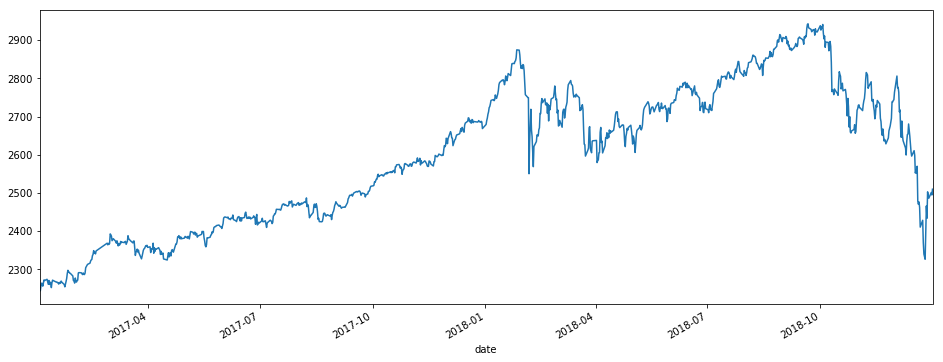

In [25]:
test_data['price'].plot(figsize=(16,6))

## Test the model

In [26]:
# Remove datetime index
test_data.reset_index(inplace=True)
# Add features
test_data = add_features(test_data.copy())
# Remove NA rows
test_data = test_data.replace([np.inf, -np.inf], np.nan)
test_data = test_data.dropna()
# Make a new blank columns for predictions
test_data['next_prediction'] = np.NaN
# Reset index
test_data.reset_index(inplace=True)

In [27]:
# Add a prediction for each row
for i in range(len(test_data)):
    test_data.at[i, 'next_prediction'] = model.predict(test_data[features].iloc[[i]])

In [28]:
test_data[['price', 'next_prediction']].tail(5)

,price,next_prediction
924,2493.469,-1.0
925,2486.270,1.0
926,2501.070,-1.0
927,2494.670,1.0
928,2509.770,-1.0


In [29]:
test_data['next_prediction'].value_counts()

-1.0    536
 1.0    393
Name: next_prediction, dtype: int64

In [30]:
# add columns for price direction and predicted direction
test_data['next_direction'] = np.where(test_data['price'] > test_data['price'].shift(-1), -1, 1)
test_data['correct'] = test_data['next_prediction'] == test_data['next_direction']

In [31]:
# How often does the model predict the correct price change direction
test_data['correct'].value_counts()

False    489
True     440
Name: correct, dtype: int64

## Trade results

In [50]:
# Create a column for the position we should take
test_data['position'] = test_data['next_prediction']

In [51]:
trades = trade_functions.create_trades_from_positions(test_data.copy())

In [52]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable
0,2017-05-15 12:00:00,2396.500,2017-05-17 12:00:00,2362.500,4,1.0,-34.000,False
1,2017-05-17 12:00:00,2362.500,2017-05-18 12:00:00,2364.000,2,-1.0,-1.500,False
2,2017-05-18 12:00:00,2364.000,2017-05-19 00:00:00,2382.750,1,1.0,18.750,True
3,2017-05-19 00:00:00,2382.750,2017-05-19 12:00:00,2382.000,1,-1.0,0.750,True
4,2017-05-19 12:00:00,2382.000,2017-05-22 00:00:00,2389.500,2,1.0,7.500,True
...,...,...,...,...,...,...,...,...
270,2018-12-19 12:00:00,2478.569,2018-12-28 00:00:00,2493.469,13,1.0,14.900,True
271,2018-12-28 00:00:00,2493.469,2018-12-28 12:00:00,2486.270,1,-1.0,7.199,True
272,2018-12-28 12:00:00,2486.270,2018-12-30 12:00:00,2501.070,1,1.0,14.800,True
273,2018-12-30 12:00:00,2501.070,2018-12-31 00:00:00,2494.670,1,-1.0,6.400,True


In [56]:
trade_functions.get_trade_statistics(trades)

Profitable: 49.82%
Ratio of long to short positions: 1.01
Median profit: 0.0
Total profit: -436.07
Median position length: 2.0
Number of trades: 275
